In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

@triton.jit
def d_leacky_relu_inv_backward(x):
    return tl.where(x >= 0, 1.0, 0.01)


In [3]:
@triton.jit
def _mlp_wide_kernel_bwd_dx(
    pid_h, pid_b,
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp_bwd_dx
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    x_ptrs = x_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_xb + offs_d[None, :] * stride_xd)
    x_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

    do_ptrs = do_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_dob + offs_d[None, :] * stride_dod)
    do_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

    w1_ptrs = w1_ptr + ((pid_h * D + offs_d[:, None]) * stride_w1d + offs_e[None, :] * stride_w1e)
    w2_ptrs = w2_ptr + ((pid_h * E + offs_e[:, None]) * stride_w2e + offs_d[None, :] * stride_w2d)

    dw1_ptrs = dw1_ptr + ((pid_h * D + offs_d[:, None]) * stride_dw1d + offs_e[None, :] * stride_dw1e)
    dw2_ptrs = dw2_ptr + ((pid_h * E + offs_e[:, None]) * stride_dw2e + offs_d[None, :] * stride_dw2d)

    x = tl.load(x_ptrs, mask=x_mask, other=0.0) # BLOCK_SIZE_B, D
    do = tl.load(do_ptrs, mask=do_mask, other=0.0) # BLOCK_SIZE_B, D
    dx = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)  # BLOCK_SIZE_B, D

    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):

        w1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - e * BLOCK_SIZE_E)
        w2_mask = (offs_e[:, None] < E - e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

        w1 = tl.load(w1_ptrs, mask=w1_mask, other=0.0) # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs, mask=w2_mask, other=0.0) # BLOCK_SIZE_E, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu_inv_backward(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            dz = dh.to(TARGET_TYPE)

        dx += tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)             # BLOCK_SIZE_B, D

        w1_ptrs += BLOCK_SIZE_E * stride_w1e
        w2_ptrs += BLOCK_SIZE_E * stride_w2e
        dw1_ptrs += BLOCK_SIZE_E * stride_dw1e
        dw2_ptrs += BLOCK_SIZE_E * stride_dw2e

    return dx


In [4]:
@triton.jit
def _mlp_wide_kernel_bwd_dw1w2(
    pid_h, pid_e,
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp_bwd_dw1w2
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    x_ptrs = x_ptr + ((pid_h * B + offs_b[:, None]) * stride_xb + offs_d[None, :] * stride_xd)

    do_ptrs = do_ptr + ((pid_h * B + offs_b[:, None]) * stride_dob + offs_d[None, :] * stride_dod)
    do_mask = (offs_b[:, None] < B) & (offs_d[None, :] < D)

    w1_ptrs = w1_ptr + ((pid_h * D + offs_d[:, None]) * stride_w1d + (pid_e * BLOCK_SIZE_E + offs_e[None, :]) * stride_w1e)
    w1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
    w2_ptrs = w2_ptr + ((pid_h * E + pid_e * BLOCK_SIZE_E + offs_e[:, None]) * stride_w2e + offs_d[None, :] * stride_w2d)
    w2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

    w1 = tl.load(w1_ptrs, mask=w1_mask, other=0.0)                      # D, BLOCK_SIZE_E
    w2 = tl.load(w2_ptrs, mask=w2_mask, other=0.0)                      # BLOCK_SIZE_E, D
    do = tl.load(do_ptrs, mask=do_mask, other=0.0)                      # BLOCK_SIZE_B, D

    dw1 = tl.zeros((D, BLOCK_SIZE_E), dtype=tl.float32)                 # D, BLOCK_SIZE_E
    dw2 = tl.zeros((BLOCK_SIZE_E, D), dtype=tl.float32)                 # BLOCK_SIZE_E, D
    for b in range(0, tl.cdiv(B, BLOCK_SIZE_B)):

        x_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)
        do_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

        x = tl.load(x_ptrs, mask=x_mask, other=0.0)                     # BLOCK_SIZE_B, D
        do = tl.load(do_ptrs, mask=do_mask, other=0.0)                  # BLOCK_SIZE_B, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        dw2 += tl.dot(tl.trans(h), do, out_dtype=tl.float32)            # BLOCK_SIZE_E, D
        # tl.store(dw2_ptrs, dw2, mask=dw2_mask, eviction_policy="evict_last")

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu_inv_backward(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            dz = dh.to(TARGET_TYPE)

        dw1 += tl.dot(tl.trans(x), dz, out_dtype=tl.float32)             # D, BLOCK_SIZE_E

        x_ptrs += BLOCK_SIZE_B * stride_xb
        do_ptrs += BLOCK_SIZE_B * stride_dob

    return dw1, dw2


In [5]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['H', 'B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_bwd2(
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid = tl.program_id(axis=0)
    pid_x_w = 0

    # batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    batch_groups_e = tl.cdiv(E, BLOCK_SIZE_E)
    batch_groups_b = tl.cdiv(B, BLOCK_SIZE_B)
    idx = pid % (batch_groups_e + batch_groups_b)
    pid_h = pid // (batch_groups_e + batch_groups_b)
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    if idx >= batch_groups_e:

        pid_b = idx - batch_groups_e

        dx_ptrs = dx_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_dxb + offs_d[None, :] * stride_dxd)
        dx_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

        dx = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)  # BLOCK_SIZE_B, D
        dx = _mlp_wide_kernel_bwd_dx(
            pid_h, pid_b,
            x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
            H, B, D, E,
            stride_xb, stride_xd,
            stride_w1d, stride_w1e,
            stride_w2e, stride_w2d,
            stride_ob, stride_od,
            stride_dxb, stride_dxd,
            stride_dw1d, stride_dw1e,
            stride_dw2e, stride_dw2d,
            stride_dob, stride_dod,
            BLOCK_SIZE_B, BLOCK_SIZE_E,
            ACTIVATION
        )

        tl.store(dx_ptrs, dx.to(TARGET_TYPE), mask=dx_mask)

    else:

        pid_e = idx

        dw1_ptrs = dw1_ptr + ((pid_h * D + offs_d[:, None]) * stride_dw1d + (pid_e * BLOCK_SIZE_E + offs_e[None, :]) * stride_dw1e)
        dw1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
        dw2_ptrs = dw2_ptr + ((pid_h * E + pid_e * BLOCK_SIZE_E + offs_e[:, None]) * stride_dw2e + offs_d[None, :] * stride_dw2d)
        dw2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

        dw1, dw2 = _mlp_wide_kernel_bwd_dw1w2(
            pid_h, pid_e,
            x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
            H, B, D, E,
            stride_xb, stride_xd,
            stride_w1d, stride_w1e,
            stride_w2e, stride_w2d,
            stride_ob, stride_od,
            stride_dxb, stride_dxd,
            stride_dw1d, stride_dw1e,
            stride_dw2e, stride_dw2d,
            stride_dob, stride_dod,
            BLOCK_SIZE_B, BLOCK_SIZE_E,
            ACTIVATION
        )

        tl.store(dw1_ptrs, dw1.to(TARGET_TYPE), mask=dw1_mask)
        tl.store(dw2_ptrs, dw2.to(TARGET_TYPE), mask=dw2_mask)


In [6]:
def mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=""):
    # Check constraints.
    assert x.shape[-1] == w1.shape[-2], "Incompatible dimensions"
    assert w1.shape[-1] == w2.shape[-2], "Incompatible dimensions"
    assert x.shape[-1] == w2.shape[-1], "Incompatible dimensions"
    assert x.shape == o.shape, "Incompatible dimensions"
    assert x.shape == do.shape, "Incompatible dimensions"

    H, B, D = x.shape
    E = w1.shape[-1]

    x = x.view(H * B, D)
    w1 = w1.view(D * H, E)
    w2 = w2.view(E * H, D)
    o = o.view(H * B, D)
    do = do.view(H * B, D)

    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert o.is_contiguous(), "Matrix O must be contiguous"
    assert do.is_contiguous(), "Matrix dO must be contiguous"


    # Allocates output.
    dx = torch.zeros_like(x)
    dw1 = torch.zeros_like(w1)
    dw2 = torch.zeros_like(w2)
    # print(dx.shape, dw1.shape, dw2.shape, do.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        # triton.cdiv(B, META['BLOCK_SIZE_B']) * H,
        (triton.cdiv(B, META['BLOCK_SIZE_B']) + triton.cdiv(E, META['BLOCK_SIZE_E'])) * H,
    )
    mlp_wide_kernel_bwd2[grid](
        x, w1, w2, o, dx, dw1, dw2, do,
        H, B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        dx.stride(0), dx.stride(1),
        dw1.stride(0), dw1.stride(1),
        dw2.stride(0), dw2.stride(1),
        do.stride(0), do.stride(1),
        ACTIVATION=activation
    )

    # print(dx.shape, dw1.shape, dw2.shape)
    return dx.view(H, B, D), dw1.view(H, D, E), dw2.view(H, E, D)


In [7]:
def mlp_torch_bwd(x, w1, w2, o, do, activation=""):
    # x: H, B, D
    # w1: H, D, E
    # w2: H, E, D
    # o: H, B, D
    # do: H, B, D
    z = torch.bmm(x, w1) # H, B, E
    if activation == "leaky_relu":
        h = torch.nn.functional.leaky_relu(z, negative_slope=0.01)
    else:
        h = z

    dh = torch.bmm(do, torch.transpose(w2, -1, -2)) # H, B, E
    dw2 = torch.bmm(torch.transpose(h, -1, -2), do) # H, E, D

    if activation == "leaky_relu":
        dz = dh * torch.where(z >= 0, 1.0, 0.01).to(dh.dtype)  # H, B, E
    else:
        dz = dh

    dx = torch.bmm(dz, torch.transpose(w1, -1, -2)) # H, B, D
    dw1 = torch.bmm(torch.transpose(x, -1, -2), dz) # H, D, E

    return dx, dw1, dw2


In [8]:
def unit_test_bwd2():
    # torch.manual_seed(19)
    DTYPE = torch.float16
    B = 1024
    D = 64
    E = 768
    H = E // D

    x = torch.randn((H, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    w1 = torch.randn((H, D, E), device='cuda', dtype=DTYPE) / np.sqrt(E)
    w2 = torch.randn((H, E, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    o = torch.randn((H, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = torch.randn((H, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    triton_output = mlp_wide_triton_bwd2(x, w1, w2, o, do, activation="leaky_relu")
    torch_output = mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu")

    print(f"triton_output={triton_output[1].shape, triton_output[1]}")
    print(f"torch_output={torch_output[1].shape, torch_output[1]}")

    eplison = 3e-2
    if torch.allclose(triton_output[1], torch_output[1], atol=eplison, rtol=eplison):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    dx_diff = np.abs(triton_output[0].to(torch.float32).cpu().numpy() - torch_output[0].to(torch.float32).cpu().numpy())
    dx_rel_diff = dx_diff / np.abs(triton_output[0].to(torch.float32).cpu().numpy() + torch_output[0].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dx: {triton_output[0].shape}, {torch_output[0].shape}] max diff: {np.max(dx_diff):.2e}, mean diff: {np.mean(dx_diff):.2e}, rel max diff: {np.max(dx_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dx_rel_diff)*100:.2f}%")

    dw1_diff = np.abs(triton_output[1].to(torch.float32).cpu().numpy() - torch_output[1].to(torch.float32).cpu().numpy())
    dw1_rel_diff = dw1_diff / np.abs(triton_output[1].to(torch.float32).cpu().numpy() + torch_output[1].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dw1: {triton_output[1].shape}, {torch_output[1].shape}] max diff: {np.max(dw1_diff):.2e}, mean diff: {np.mean(dw1_diff):.2e}, rel max diff: {np.max(dw1_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw1_rel_diff)*100:.2f}%")

    dw2_diff = np.abs(triton_output[2].to(torch.float32).cpu().numpy() - torch_output[2].to(torch.float32).cpu().numpy())
    dw2_rel_diff = dw2_diff / np.abs(triton_output[2].to(torch.float32).cpu().numpy() + torch_output[2].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dw2: {triton_output[2].shape}, {torch_output[2].shape}] max diff: {np.max(dw2_diff):.2e}, mean diff: {np.mean(dw2_diff):.2e}, rel max diff: {np.max(dw2_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw2_rel_diff)*100:.2f}%")

unit_test_bwd2()


triton_output=(torch.Size([12, 64, 768]), tensor([[[ 2.3547e-01, -8.4595e-02,  2.4060e-01,  ..., -3.1714e-01,
           2.1704e-01, -2.0203e-01],
         [-1.4847e-02, -4.5728e-01, -3.8086e-01,  ..., -4.8126e-02,
          -5.9717e-01,  9.3506e-02],
         [-8.7708e-02, -6.3782e-02, -2.5659e-01,  ..., -6.9434e-01,
          -6.6602e-01, -3.7256e-01],
         ...,
         [ 1.1121e-01,  4.1528e-01, -7.7698e-02,  ...,  1.2810e-02,
           1.1316e-01, -3.6499e-01],
         [-6.6650e-02, -3.6890e-01, -5.0342e-01,  ...,  5.7178e-01,
          -2.7246e-01,  6.4404e-01],
         [ 6.1310e-02,  2.2717e-01,  3.2104e-02,  ..., -3.1152e-01,
          -6.7529e-01,  7.3730e-01]],

        [[-1.1749e-01,  7.2449e-02, -5.7648e-02,  ...,  4.7363e-02,
           3.4204e-01, -3.8159e-01],
         [ 1.3391e-01,  3.6865e-01,  7.4280e-02,  ...,  7.4414e-01,
           3.0176e-01,  1.0996e+00],
         [ 4.1284e-01, -4.4702e-01,  6.2402e-01,  ...,  4.8242e-01,
          -1.6968e-01, -8.8806e-02

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 20)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-.'), ('blue', '-.'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd2(E, provider):
    DTYPE = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    B = 1024 * 4

    x = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=DTYPE) / np.sqrt(E)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    o = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd2(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


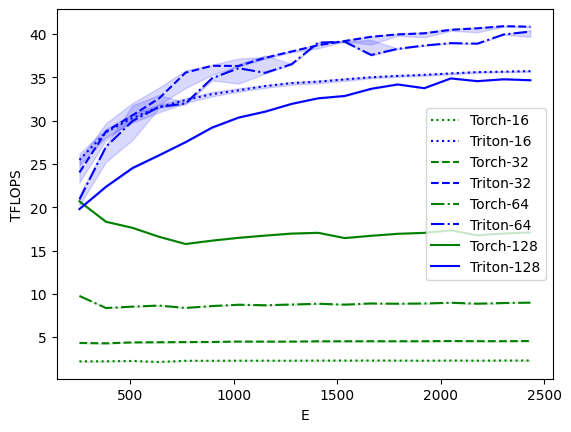

mlp-performance:
         E  Torch-16  Triton-16  Torch-32  Triton-32  Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  2.201349  25.471483  4.324025  24.013192  9.754195  20.901848  20.682822   19.790286
1    384.0  2.208077  28.668113  4.282482  28.736310  8.358888  26.975425  18.326853   22.362995
2    512.0  2.246146  30.308859  4.387347  30.615359  8.519237  29.959315  17.623125   24.528093
3    640.0  2.133131  31.551935  4.407634  32.564471  8.642110  31.583614  16.591392   25.997752
4    768.0  2.265015  32.374558  4.424371  35.544947  8.370008  31.990454  15.754898   27.513657
5    896.0  2.264277  33.063207  4.435065  36.336791  8.588181  34.897143  16.143765   29.203162
6   1024.0  2.278584  33.509752  4.484138  36.314321  8.738133  36.054188  16.469780   30.356843
7   1152.0  2.274020  33.991284  4.478259  37.258170  8.679450  35.522649  16.725491   31.042304
8   1280.0  2.275646  34.342009  4.480456  37.991883  8.762473  36.522493  16.958102   31.936323
9   1408.0  2

In [10]:
benchmark_bwd2.run(show_plots=True, print_data=True)


In [11]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['HEAD'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            i * 2 for i in range(2, 24)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-.'), ('blue', '-.'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd3(HEAD, provider):
    DTYPE = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    E = 768
    # HEAD = 384 // D
    B = 1024 * 4

    x = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=DTYPE) / np.sqrt(E)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    o = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd2(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


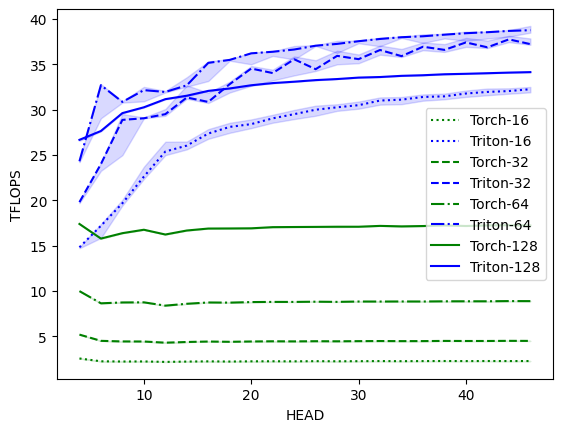

mlp-performance:
    HEAD  Torch-16  Triton-16  Torch-32  Triton-32  Torch-64  Triton-64  Torch-128  Triton-128
0    4.0  2.540976  14.803426  5.173895  19.784452  9.970612  24.291337  17.379713   26.658711
1    6.0  2.229958  17.178038  4.485354  23.994111  8.626311  32.689964  15.768060   27.634506
2    8.0  2.206029  19.660800  4.421262  28.859890  8.719966  30.840471  16.362695   29.606851
3   10.0  2.214054  22.598621  4.412889  29.036374  8.733282  32.140262  16.741501   30.247385
4   12.0  2.162508  25.368774  4.283423  29.491201  8.370008  31.939702  16.215093   31.145821
5   14.0  2.199370  26.024637  4.358689  31.330001  8.574595  32.672280  16.656653   31.524832
6   16.0  2.224701  27.354156  4.409810  30.840471  8.718456  35.147800  16.872829   32.058375
7   18.0  2.202912  28.086857  4.379881  32.805970  8.700538  35.478134  16.882262   32.326619
8   20.0  2.227222  28.391046  4.415676  34.523389  8.762702  36.199402  16.898888   32.679440
9   22.0  2.234182  29.029369  4.

In [12]:
benchmark_bwd3.run(show_plots=True, print_data=True)
